### Machine Learning: TF Audio Classification Model Creation and Training Evaluation Document
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
import os
from netplot import ModelPlot
from tensorflow.keras.utils import plot_model
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.7.0
Num GPUs Available:  0


### MFCC CNN
In this section we will construct our MFCC CNN

In [2]:
# os path to desktop
desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')

dataset_root_dir = os.path.join(desktop_path, 'kaggle_2018_dataset')
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load the training data
dataset_train_folder = os.path.join(dataset_root_dir, 'train')
dataset_train_csv = os.path.join(dataset_train_folder, 'catalog.csv')

# load in our data_frame
metadata = pd.read_csv(dataset_train_csv)

# Pre-processed MFCC coefficients
X = np.load( os.path.join(data_npy_folder, "X-mfcc.npy" ) )
y = np.load( os.path.join(data_npy_folder, "y-mfcc.npy" ) )


In [3]:
# create train and test sets
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))


Test split: 1894 		 Train split: 7579
X test shape: (1894, 40, 2584) 	 X train shape: (7579, 40, 2584)
y test shape: (1894,) 		 y train shape: (7579,)


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))


In [5]:
y_test[2]

'Gong'

In [6]:
y_test_encoded[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [7]:
# How data should be structured
num_rows = 40
num_columns = 2584 
num_channels = 1

# Reshape to fit the network input (channel last)

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [8]:
num_labels

41

In [9]:
# set the random seed
tf.random.set_seed(42)


# IMAGE_HEIGHT = X_train.shape[0]#spectrogram_shape[0]
# IMAGE_WIDTH = X_train.shape[1]#40#spectrogram_shape[1]
# N_CHANNELS = X_train.shape[2]#2584#2
#N_CLASSES = num_labels#len(y_train_encoded)

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

# Create a secquential object
model = Sequential()


# Conv 1
model.add(Conv2D(filters=32, 
                    kernel_size=(3, 3), 
                    kernel_regularizer=l2(l2_rate), 
                    input_shape=(num_rows, num_columns, num_channels)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(SpatialDropout2D(spatial_dropout_rate_1))
model.add(Conv2D(filters=32, 
                    kernel_size=(3, 3), 
                    kernel_regularizer=l2(l2_rate)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())


# Max Pooling #1
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(SpatialDropout2D(spatial_dropout_rate_1))
model.add(Conv2D(filters=64, 
                    kernel_size=(3, 3), 
                    kernel_regularizer=l2(l2_rate)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(SpatialDropout2D(spatial_dropout_rate_2))
model.add(Conv2D(filters=64, 
                    kernel_size=(3,3), 
                    kernel_regularizer=l2(l2_rate)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())


# Reduces each h×w feature map to a single number by taking the average of all h,w values.
model.add(GlobalAveragePooling2D())


# Softmax output
model.add(Dense(num_labels, activation='softmax'))

# # Create CNN model
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=(num_rows, num_columns, num_channels)))
# model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))


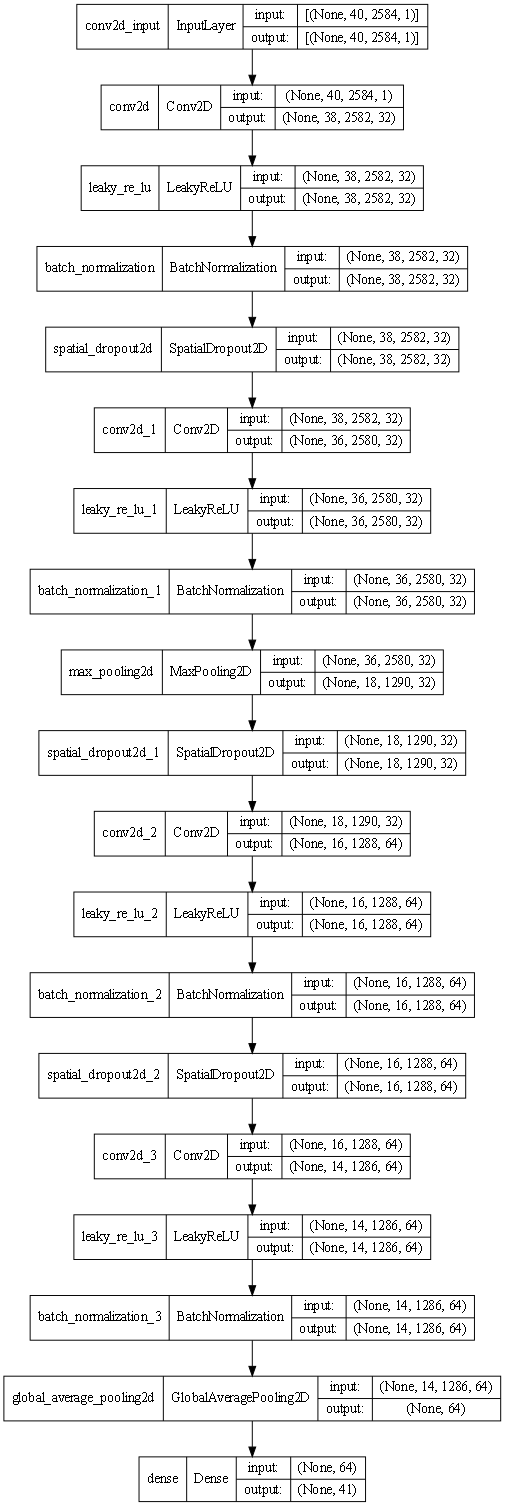

In [10]:
# 2. compile the model
model.compile(
    loss = tf.keras.losses.mae, # mean absolute error predicted vs observed
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), # stochastic gradient descent (lr=1e-3)
    metrics=['mae'] # mean absolute error
)

plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

In [11]:
# modelplot = ModelPlot(model=model, grid=True, connection=False, linewidth=0.1)
# modelplot.show()

In [11]:
# get the directory of the model output
model_dir = os.path.join( dataset_root_dir, 'models')
model_path = os.path.join(model_dir, 'MLAC_K2018_MFCC.h5')

# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# # early stopping callback
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='mae',
#     patience=3
# )

from datetime import datetime
start = datetime.now()

# 3. train the model

num_epochs = 250
num_batch_size = 128

history = model.fit(
    X_train, 
    y_train_encoded, 
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    validation_split=1/12.,
    callbacks=[checkpointer], 
    verbose=1
)

# history = model.fit(
#     X_train,
#     y_train_encoded,
#     epochs=250,
#     verbose=1,
#     callbacks=[early_stopping_callback, checkpointer],
#     validation_data=(X_test, y_test_encoded)
# )

end = datetime.now() - start
print("Training time: {}".format(end))

Epoch 1/250
 2/55 [>.............................] - ETA: 20:29 - loss: 0.1177 - mae: 0.0477